In [1]:
#install.packages("RSQLite")
#install.packages("bbmle")

In [2]:
options(repr.plot.width=8,repr.plot.height=4)

In [3]:
library(DBI)
con <- dbConnect(RSQLite::SQLite(), "datasets/wjazzd.db")

## Canciones por estilo

In [4]:
solos <- dbReadTable(con, "solo_info")

In [5]:
solos.styles <- data.frame(table(solos$style))
colnames(solos.styles)[1] <- 'Style'
solos.styles

Style,Freq
BEBOP,56
COOL,54
FREE,5
FUSION,20
HARDBOP,76
POSTBOP,147
SWING,66
TRADITIONAL,32


## Canciones por métrica

In [6]:
solos.metrics <- data.frame(table(solos$signature))
colnames(solos.metrics)[1] <- 'Metric'
solos.metrics

Metric,Freq
,8
3/4,8
4/4,435
5/4,1
6/4,1
6/8,1
9/4,2


Queremos ver si los estilos se diferencian por la distribución de notas en el compás. Considerando la distribución desproporcionada de canciones en 4/4, nos restringimos a este subconjunto de solos.

In [7]:
solos.44 <- solos[solos$signature == '4/4',]

In [8]:
melody <- dbReadTable(con, 'melody')

In [9]:
melody.44 <- melody[melody$melid %in% solos.44$melid,]

In [10]:
x <- merge(melody.44, solos.44, by.x='melid', by.y='melid') # Unimos las notas con el estilo de la canción a la que 
duration.and.style <- x[c('melid', 'duration', 'style')]

### Ejemplos por estilo

In [11]:
set.seed(123)
d <- lapply(unique(solos$style), function(s) {
    xs <- solos[solos$style == s, ][sample(1:sum(solos$style == s), 5), ]
    out <- sapply(1:nrow(xs), function(i) { sprintf('%s - %s', xs[i, 'performer'], xs[i, 'title']) })
})
d <- data.frame(d)
colnames(d) <- unique(solos$style)
d

COOL,SWING,TRADITIONAL,POSTBOP,FUSION,HARDBOP,BEBOP,FREE
Gerry Mulligan - Line for Lyons,Benny Carter - Just Friends,Sidney Bechet - Really the Blues,Woody Shaw - Dat Dere,Steve Coleman - Cross-Fade,Nat Adderley - Work Song,Sonny Stitt - Elora,Ornette Coleman - Congeniality
Stan Getz - Crazy Rhythm,Dickie Wells - Jo-Jo,Kid Ory - Got No Blues,Don Ellis - Out of Nowhere,Miles Davis - Miles Runs the Voodoo Down,Kenny Dorham - Prince Albert,Phil Woods - Strollin' with Pam,Ornette Coleman - Peace
Lee Konitz - Bop Goes to Leesel,Lionel Hampton - Runnin' Wild,Louis Armstrong - Big Butter and Egg Man,Branford Marsalis - Gutbucket Steepy,Miles Davis - Bitches Brew,Lee Morgan - The Sidewinder,J.J. Johnson - Yesterdays,Ornette Coleman - Bird Food
Warne Marsh - Crosscurrent,Roy Eldridge - The Gasser,Kid Ory - Muskrat Ramble,Freddie Hubbard - Maiden Voyage,Steve Coleman - Cross-Fade,Freddie Hubbard - Society Red,Milt Jackson - Don't Get Around Much Anymore,Ornette Coleman - Ramblin'
Warne Marsh - Wow,Coleman Hawkins - Sophisticated Lady,Bix Beiderbecke - Riverboat Shuffle,Woody Shaw - Rahsaan's Run,Miles Davis - Bitches Brew,Clifford Brown - Joy Spring,Charlie Parker - Blues for Alice,Ornette Coleman - Chronology


### Duración de las notas

Queremos ver si hay diferencias notables entre las improvisaciones de distintos estilos. Empezamos enfocándonos en la duración de las notas. 

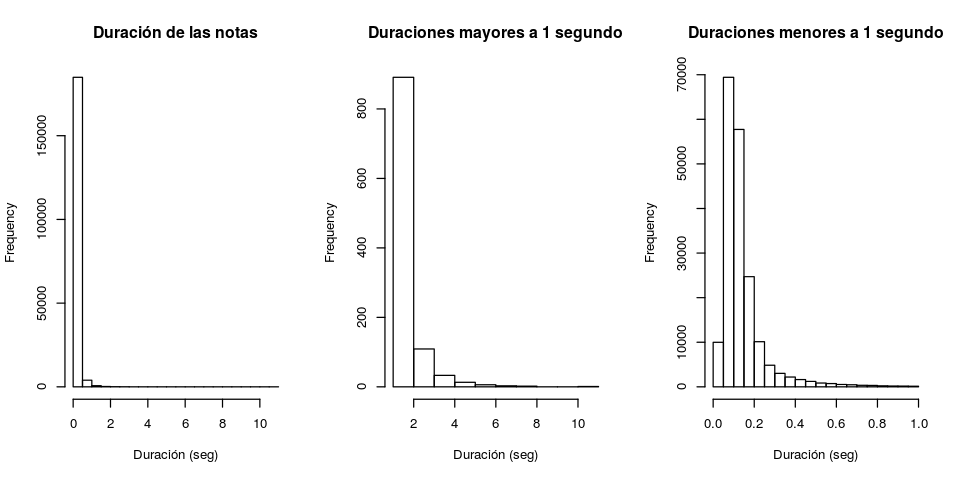

In [12]:
par(mfrow=c(1,3))
hist(duration.and.style$duration, main='Duración de las notas', xlab='Duración (seg)')
hist(duration.and.style$duration[duration.and.style$duration > 1],
    main='Duraciones mayores a 1 segundo', xlab='Duración (seg)')
hist(duration.and.style$duration[duration.and.style$duration <= 1],
    main='Duraciones menores a 1 segundo', xlab='Duración (seg)')

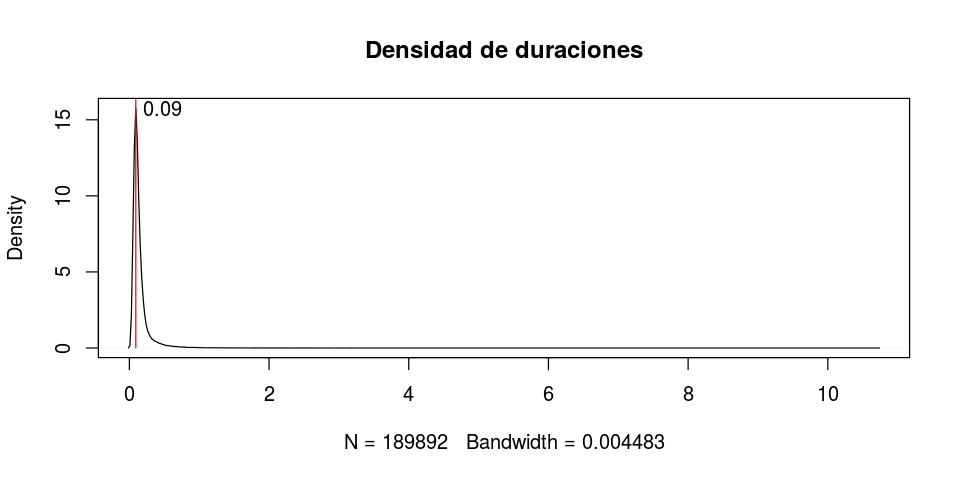

In [13]:
d <- density(duration.and.style$duration, kernel='gaus')
plot(d,  main='Densidad de duraciones')
x.max <- d$x[which.max(d$y)]
lines(rep(x.max, 2), c(0, max(d$y) + 2), col='red')
text(x.max + 0.1, max(d$y), labels=c(round(x.max,2)), adj=c(0, 0.5))

Asumimos que la distribución es una gamma y estimamos los parámetros. Nos concentramos en las duraciones menores a 1 s. Usamos los estimadores de momentos.

In [14]:
gamma.alpha.mme.est <- function(ma) {
    (mean(ma) ** 2) / (mean((ma - mean(ma)) ** 2))
}
gamma.lambda.mme.est <- function(ma) {
    (mean(ma) ** 1) / (mean((ma - mean(ma)) ** 2))
}

gamma.ma <- rgamma(10000, 3, 5)
stopifnot(abs(gamma.alpha.mme.est(gamma.ma) - 3) < 0.2)
stopifnot(abs(gamma.lambda.mme.est(gamma.ma) - 5) < 0.2)

[1] "alpha = 1.63, lambda = 11.67"


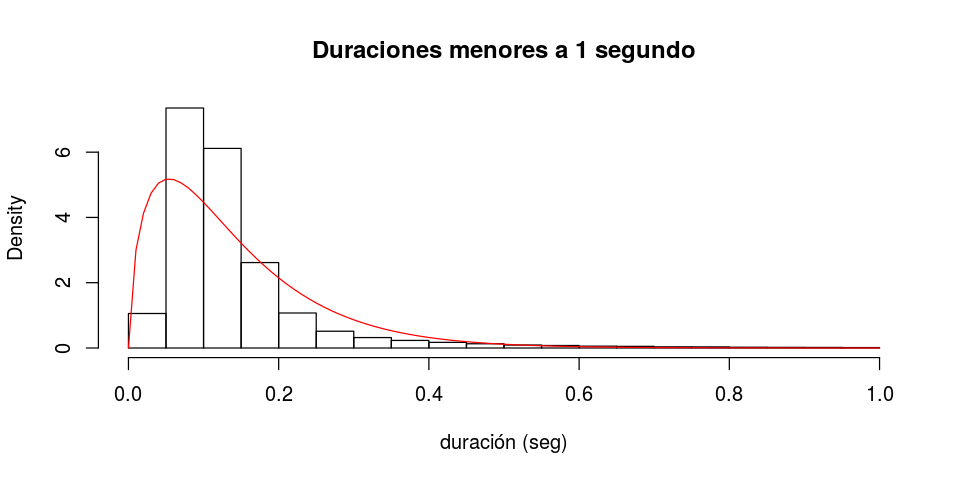

In [15]:
menor_1 = duration.and.style$duration[duration.and.style$duration < 1]
duracion.alpha.mme.est <- gamma.alpha.mme.est(menor_1)
duracion.lambda.mme.est <- gamma.lambda.mme.est(menor_1)
print(sprintf('alpha = %.2f, lambda = %.2f', duracion.alpha.mme.est, duracion.lambda.mme.est))
hist(duration.and.style$duration[duration.and.style$duration < 1], 
     main='Duraciones menores a 1 segundo', xlab='duración (seg)', freq=F)
xs <- seq(0.0, 1, 0.01)
lines(xs, dgamma(xs, duracion.alpha.mme.est, duracion.lambda.mme.est), col='red')

Viendo que la densidad no queda tan ajustada al histograma, probamos con los estimadores de máxima verosimilitud.

In [16]:
library(bbmle)

Loading required package: stats4


In [17]:
gamma.alpha.nll = function(a, ma=duration.and.style$duration) {
    ll = length(ma) * a * (log(a) - log(mean(ma))) - length(ma) * lgamma(a) + (a - 1) * sum(log(ma)) - a * length(ma)
    -ll
}
emv = mle2(gamma.alpha.nll, start=list(a=duracion.alpha.mme.est), data=list(ma=duration.and.style$duration))

Warning message in log(a):
“NaNs produced”

In [18]:
duracion.alpha.emv.est = coef(emv)
duracion.lambda.emv.est = duracion.alpha.emv.est / mean(menor_1)

[1] "alpha = 2.33, lambda = 16.67"


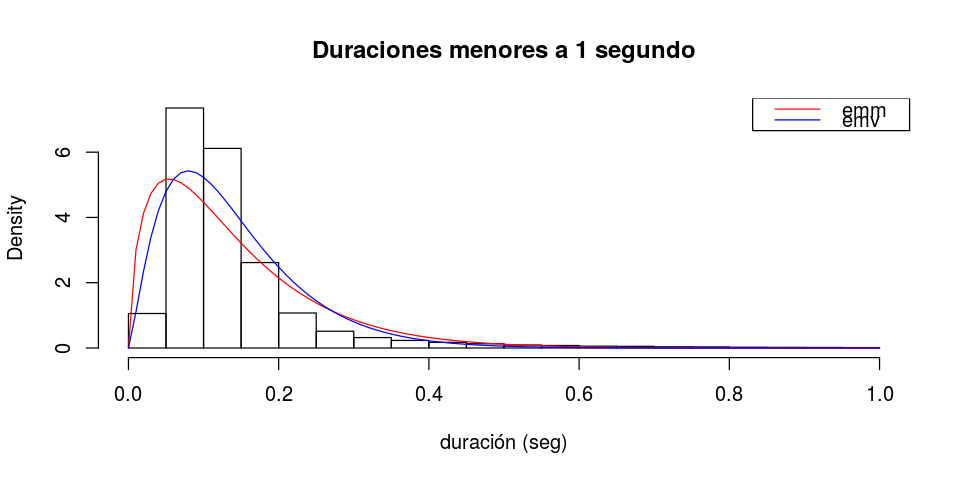

In [19]:
print(sprintf('alpha = %.2f, lambda = %.2f', duracion.alpha.emv.est, duracion.lambda.emv.est))
hist(duration.and.style$duration[duration.and.style$duration < 1], 
     main='Duraciones menores a 1 segundo', xlab='duración (seg)', freq=F)
xs <- seq(0.0, 1, 0.01)
lines(xs, dgamma(xs, duracion.alpha.mme.est, duracion.lambda.mme.est), col='red')
lines(xs, dgamma(xs, duracion.alpha.emv.est, duracion.lambda.emv.est), col='blue')
legend('topright', legend=c('emm', 'emv'), lty=rep(1, 2), lwd=rep(1, 2), col=c('red', 'blue'))

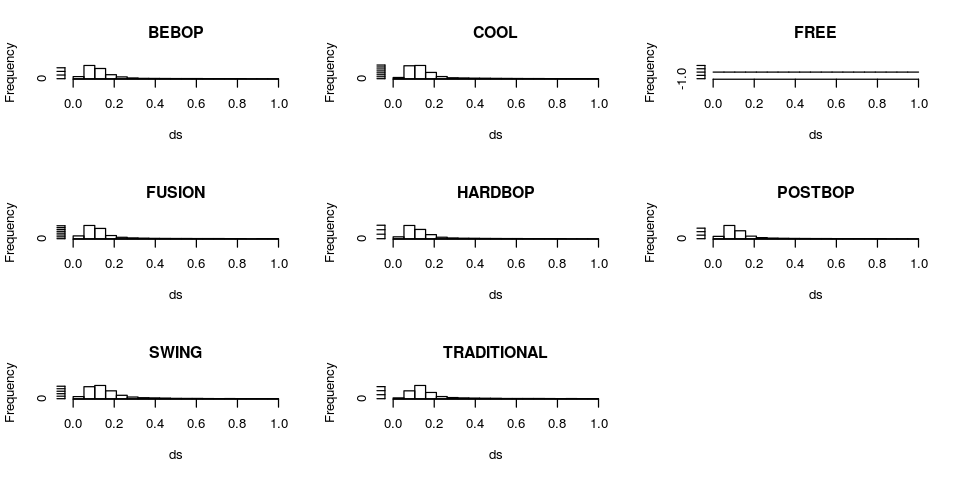

In [42]:
par(mfrow=c(ceiling(length(solos.styles[,1]) / 3), 3))
duration_1.and.style = duration.and.style[duration.and.style$duration < 1,]
breaks = seq(0, 1, length.out=20)
for (s in solos.styles[,1]) {
    ds = duration_1.and.style$duration[duration_1.and.style$style == s]
    hist(ds, breaks=breaks, main=s)
}

In [ ]:
u
styles <- unique(solos.44$style)
cols = c('orange', 'cyan', 'magenta', 'green', 'grey', 'brown', 'limegreen')
ymax = 0
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    durations <- duration.and.style[duration.and.style$style == style,]
    ymax = max(density(durations$duration)$y, ymax)
}
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    durations <- duration.and.style[duration.and.style$style == style,]
    d <- density(durations$duration)
    if (style_idx == 1) {
        plot(d, ylim=c(0, ymax), xlim=c(0, 0.4), col=cols[style_idx])
    } else {
        lines(d, col=cols[style_idx])
    }
}
legend('topright', legend=styles, lty=rep(1, length(styles)), lwd=rep(1, length(styles)), col=cols)